In [1]:
import pandas as pd
import numpy as np

In [60]:
data_dir = '../data/train_test'
selected_bands = ['B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B09', 'B11', 'B12']

## Data preprocessing

### Augmenting rows

In [61]:
def add_column_statistics(df, columns, by_column=None, add_std=False):
    df = df.copy()

    if by_column:
        for i in columns:
            df[f'{i}_min_by_fid'] = df.groupby(by_column)[i].transform('min')
            df[f'{i}_max_by_fid'] = df.groupby(by_column)[i].transform('max')
            df[f'{i}_avg_by_fid'] = df.groupby(by_column)[i].transform('mean')

            if add_std:
                df[f'{i}_std_by_fid'] = df.groupby(by_column)[i].transform('std')
    else:
        for i in columns:
            if add_std:
                df[f'{i}_std'] = df.filter(regex = f'^{i}').std(axis = 1)
                
            df[f'{i}_max'] = df.filter(regex = f'^{i}').max(axis = 1)
            df[f'{i}_min'] = df.filter(regex = f'^{i}').min(axis = 1)
            df[f'{i}_avg'] =df.filter(regex = f'^{i}').mean(axis = 1)

    return df
    

def add_column_mappings(df, columns):
    df = df.copy()

    for i in columns:
        df[f'{i}_sqrt'] = np.sqrt(df[i])
        df[f'{i}_exp'] = np.exp(df[i])
        df[f'{i}_^2'] = df[i]**2
    
    return df

### Add spetral indices

In [62]:
spectral_indices = [
    "NDVI",
    "GNDVI",
    # "EVI",
    "EVI2",
    # "AVI",
    "BSI",
    "SI",
    "NDWI",
    "NDMI",
    "NPCRI",
    "SAVI",
    "MSI",
    "GCI",
    "NBRI",
    "NDSI",
    "NDGI",
    "ARVI",
    "SIPI",
]

def add_spectral_indices(df):
    df = df.copy()
    
    df["NDVI"] = (df["B08"] - df["B04"]) / (df["B08"] + df["B04"])
    df["GNDVI"] = (df["B08"] - df["B03"]) / (df["B08"] + df["B03"])
    # df["EVI"] = 2.5 * ((df["B08"] - df["B04"]) / ((df["B08"] + 6.0 * df["B04"] - 7.5 * df['B02']) + 1.0))
    df["EVI2"] = 2.4 * (df["B08"] - df["B04"]) / (df["B08"] + df["B04"] + 1.0)
    # df["AVI"] = (df["B08"] * (1 - df["B04"]) * (df["B08"] - df["B04"]))**(1/3)
    df["BSI"] = ((df["B11"] + df["B04"]) - (df["B08"] + df["B02"])) / ((df["B11"] + df["B04"]) + (df["B08"] + df["B02"]))
    df["SI"] = ((1 - df["B02"]) * (1 - df["B03"]) * (1 - df["B04"]))
    df["NDWI"] = (df["B03"] - df["B08"]) / (df["B03"] + df["B08"])
    df["NDMI"] = (df["B08"] - df["B11"]) / (df["B08"] + df["B11"]) 
    df["NPCRI"] = (df["B04"] - df["B02"]) / (df["B04"] + df["B02"]) 
    df["SAVI"] = (df["B08"] - df["B04"]) / (df["B08"] + df["B04"] + 0.428) * (1.428)
    df["MSI"] = df["B11"] / df["B08"]
    df["GCI"] = (df["B09"] / df["B03"]) - 1
    df["NBRI"] = (df["B08"] - df["B12"]) / (df["B08"] + df["B12"])
    df["NDSI"] = (df["B03"] - df["B11"]) / (df["B03"] + df["B11"])
    df["NDGI"] = (df["B03"] - df["B04"]) / (df["B03"] + df["B04"]) 
    df["ARVI"] = (df["B08"] - (2 * df["B04"]) + df["B02"]) / (df["B08"] + (2 * df["B04"]) + df["B02"]) 
    df["SIPI"] = (df["B08"] - df["B02"]) / (df["B08"] - df["B04"])

    return df

In [63]:
df_train = pd.read_csv(f"{data_dir}/preprocessed/tabular_train.csv")
df_test = pd.read_csv(f"{data_dir}/preprocessed/tabular_test.csv")
df_all = pd.concat([df_train, df_test])

display(df_all.head())

,B01,B02,B03,B04,B05,B06,B07,B08,B8A,B09,B11,B12,field_id,crop
0,44,40,40,42,45,59,70,63,76,13,78,55,1374,1.0
1,44,40,40,42,45,59,70,62,76,13,78,55,1374,1.0
2,44,40,39,42,46,52,58,54,62,16,72,53,3293,1.0
3,44,41,39,43,48,58,65,61,71,16,78,61,3293,1.0
4,44,40,40,44,48,58,65,64,71,16,78,61,3293,1.0


In [6]:
# spectral bands
df_all = add_column_statistics(df_all, selected_bands)
df_all = add_column_mappings(df_all, selected_bands)
df_all = add_column_statistics(df_all, selected_bands, "field_id")

# spectral indices
df_all = add_spectral_indices(df_all)
df_all = add_column_statistics(df_all, spectral_indices)
df_all = add_column_mappings(df_all, spectral_indices)
df_all = add_column_statistics(df_all, spectral_indices, "field_id")

display(df_all.head())

/home/arnol/anaconda3/envs/aic/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/arnol/anaconda3/envs/aic/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/arnol/anaconda3/envs/aic/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/arnol/anaconda3/envs/aic/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/arnol/anaconda3/envs/aic/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/arnol/anaconda3/envs/aic/lib/

,B01,B02,B03,B04,B05,B06,B07,B08,B8A,B09,...,NDSI_avg_by_fid,NDGI_min_by_fid,NDGI_max_by_fid,NDGI_avg_by_fid,ARVI_min_by_fid,ARVI_max_by_fid,ARVI_avg_by_fid,SIPI_min_by_fid,SIPI_max_by_fid,SIPI_avg_by_fid
0,44,40,40,42,45,59,70,63,76,13,...,-0.317357,-0.057471,0.0,-0.032736,0.065990,0.146067,0.091702,1.000000,1.277778,1.139093
1,44,40,40,42,45,59,70,62,76,13,...,-0.317357,-0.057471,0.0,-0.032736,0.065990,0.146067,0.091702,1.000000,1.277778,1.139093
2,44,40,39,42,46,52,58,54,62,16,...,-0.312590,-0.085106,0.0,-0.051285,0.042254,0.139535,0.073813,0.909091,1.500000,1.232843
3,44,41,39,43,48,58,65,61,71,16,...,-0.312590,-0.085106,0.0,-0.051285,0.042254,0.139535,0.073813,0.909091,1.500000,1.232843
4,44,40,40,44,48,58,65,64,71,16,...,-0.312590,-0.085106,0.0,-0.051285,0.042254,0.139535,0.073813,0.909091,1.500000,1.232843


In [7]:
df_all = df_all.join(df_all.groupby("field_id").size().rename(f'num_pixels_by_fid'), on='field_id')

df_all.head()

,B01,B02,B03,B04,B05,B06,B07,B08,B8A,B09,...,NDGI_min_by_fid,NDGI_max_by_fid,NDGI_avg_by_fid,ARVI_min_by_fid,ARVI_max_by_fid,ARVI_avg_by_fid,SIPI_min_by_fid,SIPI_max_by_fid,SIPI_avg_by_fid,num_pixels_by_fid
0,44,40,40,42,45,59,70,63,76,13,...,-0.057471,0.0,-0.032736,0.065990,0.146067,0.091702,1.000000,1.277778,1.139093,36
1,44,40,40,42,45,59,70,62,76,13,...,-0.057471,0.0,-0.032736,0.065990,0.146067,0.091702,1.000000,1.277778,1.139093,36
2,44,40,39,42,46,52,58,54,62,16,...,-0.085106,0.0,-0.051285,0.042254,0.139535,0.073813,0.909091,1.500000,1.232843,19
3,44,41,39,43,48,58,65,61,71,16,...,-0.085106,0.0,-0.051285,0.042254,0.139535,0.073813,0.909091,1.500000,1.232843,19
4,44,40,40,44,48,58,65,64,71,16,...,-0.085106,0.0,-0.051285,0.042254,0.139535,0.073813,0.909091,1.500000,1.232843,19


In [8]:
tmp = df_all.drop(columns=["crop"])

tmp.loc[:, tmp.isna().any()]

,GNDVI_sqrt,BSI_sqrt,SI_sqrt,NDWI_sqrt,NDMI_sqrt,NPCRI_sqrt,GCI_sqrt,NBRI_sqrt,NDSI_sqrt,NDGI_sqrt,ARVI_sqrt,SIPI_sqrt
0,0.472547,0.276104,NaN,NaN,NaN,0.156174,NaN,0.260378,NaN,NaN,0.318754,1.046536
1,0.464420,0.284747,NaN,NaN,NaN,0.156174,NaN,0.244600,NaN,NaN,0.311086,1.048809
2,0.401610,0.310087,NaN,NaN,NaN,0.156174,NaN,0.096674,NaN,NaN,0.237023,1.080123
3,0.469042,0.291893,NaN,NaN,NaN,0.154303,NaN,0.000000,NaN,NaN,0.291730,1.054093
4,0.480384,0.282216,NaN,NaN,NaN,0.218218,NaN,0.154919,NaN,NaN,0.288675,1.095445
...,...,...,...,...,...,...,...,...,...,...,...,...
49313,0.396059,0.337691,NaN,NaN,NaN,0.311086,NaN,0.187317,NaN,NaN,NaN,1.457738
49314,0.365148,0.349215,NaN,NaN,NaN,0.267261,NaN,NaN,NaN,NaN,0.000000,1.414214
49315,0.351562,0.350931,NaN,NaN,NaN,0.245440,NaN,NaN,NaN,NaN,0.075165,1.354006
49316,0.385922,0.325222,NaN,NaN,NaN,0.267261,NaN,0.137361,NaN,NaN,0.128037,1.290994


## Feature selection

In [9]:
from sklearn.model_selection import train_test_split

In [10]:
df_all = df_all.reset_index(drop=True)
df_all.head()

,B01,B02,B03,B04,B05,B06,B07,B08,B8A,B09,...,NDGI_min_by_fid,NDGI_max_by_fid,NDGI_avg_by_fid,ARVI_min_by_fid,ARVI_max_by_fid,ARVI_avg_by_fid,SIPI_min_by_fid,SIPI_max_by_fid,SIPI_avg_by_fid,num_pixels_by_fid
0,44,40,40,42,45,59,70,63,76,13,...,-0.057471,0.0,-0.032736,0.065990,0.146067,0.091702,1.000000,1.277778,1.139093,36
1,44,40,40,42,45,59,70,62,76,13,...,-0.057471,0.0,-0.032736,0.065990,0.146067,0.091702,1.000000,1.277778,1.139093,36
2,44,40,39,42,46,52,58,54,62,16,...,-0.085106,0.0,-0.051285,0.042254,0.139535,0.073813,0.909091,1.500000,1.232843,19
3,44,41,39,43,48,58,65,61,71,16,...,-0.085106,0.0,-0.051285,0.042254,0.139535,0.073813,0.909091,1.500000,1.232843,19
4,44,40,40,44,48,58,65,64,71,16,...,-0.085106,0.0,-0.051285,0.042254,0.139535,0.073813,0.909091,1.500000,1.232843,19


In [32]:
X_train = df_all[~df_all["crop"].isnull()]
df_test = df_all[df_all["crop"].isnull()]
y_train = X_train["crop"]

X_train = X_train.drop(columns=["field_id", "crop"])
X_test = df_test.drop(columns=["field_id", "crop"])

In [47]:
X_train.shape, y_train.shape, X_test.shape

((188228, 281), (188228,), (49318, 281))

In [13]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2, stratify = y_train, random_state = 5, shuffle = True)

In [14]:
import catboost
from catboost import CatBoostClassifier
from sklearn.metrics import log_loss
from sklearn.model_selection import cross_val_predict
from sklearn.utils.class_weight import compute_class_weight

In [15]:
label_weights = compute_class_weight("balanced", classes=np.unique(y_train), y=y_train)

In [16]:
# cb_pi --> catboost_permutation_importance\n",
cb_pi = CatBoostClassifier(n_estimators = 1400, learning_rate = 0.03, random_state = 11, task_type = "GPU")
cb_pi.fit(X_train, y_train)

0:	learn: 2.4195451	total: 54.1ms	remaining: 1m 15s
1:	learn: 2.3005404	total: 100ms	remaining: 1m 9s
2:	learn: 2.2023686	total: 144ms	remaining: 1m 7s
3:	learn: 2.1196715	total: 187ms	remaining: 1m 5s
4:	learn: 2.0476011	total: 234ms	remaining: 1m 5s
5:	learn: 1.9827399	total: 276ms	remaining: 1m 4s
6:	learn: 1.9247837	total: 319ms	remaining: 1m 3s
7:	learn: 1.8719587	total: 364ms	remaining: 1m 3s
8:	learn: 1.8230918	total: 406ms	remaining: 1m 2s
9:	learn: 1.7783691	total: 446ms	remaining: 1m 2s
10:	learn: 1.7370596	total: 488ms	remaining: 1m 1s
11:	learn: 1.7001469	total: 532ms	remaining: 1m 1s
12:	learn: 1.6654703	total: 574ms	remaining: 1m 1s
13:	learn: 1.6320735	total: 616ms	remaining: 1m
14:	learn: 1.6015821	total: 661ms	remaining: 1m 1s
15:	learn: 1.5733005	total: 704ms	remaining: 1m
16:	learn: 1.5459479	total: 746ms	remaining: 1m
17:	learn: 1.5207190	total: 786ms	remaining: 1m
18:	learn: 1.4960027	total: 830ms	remaining: 1m
19:	learn: 1.4739010	total: 867ms	remaining: 59.9s
20:

In [17]:
import eli5
from eli5.sklearn import PermutationImportance

In [18]:
pi = PermutationImportance(cb_pi, random_state = 90, n_iter = 5)
pi.fit(X_val, y_val)
eli5.show_weights(pi, feature_names = X_train.columns.tolist(), top = None)

Weight,Feature
0.0482 ± 0.0013,num_pixels_by_fid
0.0402 ± 0.0011,NDSI_min_by_fid
0.0272 ± 0.0016,NDGI_avg_by_fid
0.0258 ± 0.0006,NDGI_min_by_fid
0.0168 ± 0.0012,NBRI_min_by_fid
0.0116 ± 0.0003,NBRI_avg_by_fid
0.0090 ± 0.0008,NDSI_avg_by_fid
0.0084 ± 0.0004,B12_max_by_fid
0.0082 ± 0.0007,B02_avg_by_fid
0.0081 ± 0.0004,GCI_avg_by_fid


In [19]:
pi_results = eli5.formatters.as_dataframe.explain_weights_df(pi, feature_names = X_train.columns.tolist())
# feature importance weigth threshold is 0\n",
low_importance = pi_results[pi_results.weight <= 0].feature.values
low_importance

array(['NDMI_^2', 'B06_exp', 'B8A_sqrt', 'B08_^2', 'B08_exp', 'B08_sqrt',
       'B07_^2', 'B07_exp', 'B07_sqrt', 'B06_^2', 'B06_sqrt', 'B09_sqrt',
       'B05_^2', 'B05_exp', 'B05_sqrt', 'B04_^2', 'B04_exp', 'B04_sqrt',
       'B03_^2', 'B03_exp', 'B03_sqrt', 'B8A_^2', 'B09_exp', 'B02_exp',
       'ARVI_^2', 'GCI_^2', 'NBRI_sqrt', 'NBRI_exp', 'NBRI_^2',
       'NDSI_sqrt', 'NDMI_exp', 'ARVI_sqrt', 'ARVI_exp', 'SIPI_sqrt',
       'B09_^2', 'SIPI_exp', 'SIPI_^2', 'B12_^2', 'B12_exp', 'B12_sqrt',
       'B11_^2', 'B11_exp', 'B11_sqrt', 'B02_^2', 'B02_sqrt', 'MSI_^2',
       'B05_max', 'B04_min', 'B04_max', 'B03_avg', 'B03_min', 'B03_max',
       'B02_avg', 'B02_min', 'B02_max', 'B12', 'B11', 'B09', 'B8A', 'B08',
       'B07', 'B06', 'B05', 'B04', 'B03', 'B02', 'B04_avg', 'B05_min',
       'B12_avg', 'B05_avg', 'B12_min', 'B12_max', 'B11_avg', 'B11_min',
       'B11_max', 'B09_avg', 'B09_min', 'B8A_avg', 'B8A_min', 'B8A_max',
       'B08_avg', 'B08_min', 'B08_max', 'B07_avg', 'B07_min', '

In [20]:
features_to_drop = low_importance

In [34]:
X_train_curated = X_train.drop(columns = features_to_drop)
X_test_curated = X_test.drop(columns = features_to_drop)

X_train_curated.shape, X_test_curated.shape

((188228, 77), (49318, 77))

## Cross Validation

In [22]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import BaggingClassifier

cb = CatBoostClassifier(n_estimators = 1500, learning_rate=0.03, depth = 6, random_state = 11, bagging_temperature = 1, task_type = "GPU")

# Use "class_weights = label_weights" for cross validation
cb2 = CatBoostClassifier(n_estimators = 1100, learning_rate=0.03, depth = 6, random_state = 11, bagging_temperature = 1, task_type = "GPU", class_weights = label_weights)

lda = LinearDiscriminantAnalysis()
bc = BaggingClassifier(base_estimator = lda, n_estimators = 30, random_state = 0)
      

In [23]:
# Catboost without weights
cv1 = cross_val_predict(cb, X_train_curated, y_train, cv = 5, method = "predict_proba", verbose = 5)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0:	learn: 2.4170228	total: 27.7ms	remaining: 41.5s
1:	learn: 2.3014428	total: 46.1ms	remaining: 34.5s
2:	learn: 2.2054591	total: 66.7ms	remaining: 33.3s
3:	learn: 2.1210968	total: 85.2ms	remaining: 31.9s
4:	learn: 2.0473640	total: 104ms	remaining: 31.2s
5:	learn: 1.9814927	total: 124ms	remaining: 30.9s
6:	learn: 1.9220395	total: 143ms	remaining: 30.4s
7:	learn: 1.8690365	total: 161ms	remaining: 30.1s
8:	learn: 1.8206386	total: 181ms	remaining: 30s
9:	learn: 1.7768025	total: 204ms	remaining: 30.5s
10:	learn: 1.7359443	total: 223ms	remaining: 30.2s
11:	learn: 1.6987568	total: 242ms	remaining: 30s
12:	learn: 1.6643374	total: 263ms	remaining: 30s
13:	learn: 1.6323075	total: 282ms	remaining: 30s
14:	learn: 1.6021674	total: 302ms	remaining: 29.9s
15:	learn: 1.5738026	total: 319ms	remaining: 29.6s
16:	learn: 1.5461876	total: 339ms	remaining: 29.6s
17:	learn: 1.5206331	total: 357ms	remaining: 29.4s
18:	learn: 1.4968239	total: 375ms	remaining: 29.2s
19:	learn: 1.4742626	total: 392ms	remaining: 

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   26.4s remaining:    0.0s


0:	learn: 2.4156415	total: 17.3ms	remaining: 26s
1:	learn: 2.2992864	total: 34.8ms	remaining: 26.1s
2:	learn: 2.2029179	total: 51.5ms	remaining: 25.7s
3:	learn: 2.1181658	total: 68.6ms	remaining: 25.7s
4:	learn: 2.0449784	total: 85.7ms	remaining: 25.6s
5:	learn: 1.9795333	total: 103ms	remaining: 25.7s
6:	learn: 1.9219301	total: 120ms	remaining: 25.7s
7:	learn: 1.8688868	total: 137ms	remaining: 25.6s
8:	learn: 1.8203698	total: 154ms	remaining: 25.4s
9:	learn: 1.7766500	total: 170ms	remaining: 25.3s
10:	learn: 1.7358661	total: 186ms	remaining: 25.2s
11:	learn: 1.6988302	total: 202ms	remaining: 25.1s
12:	learn: 1.6646549	total: 218ms	remaining: 24.9s
13:	learn: 1.6327197	total: 235ms	remaining: 24.9s
14:	learn: 1.6024146	total: 251ms	remaining: 24.9s
15:	learn: 1.5734443	total: 268ms	remaining: 24.9s
16:	learn: 1.5461108	total: 286ms	remaining: 24.9s
17:	learn: 1.5210243	total: 301ms	remaining: 24.8s
18:	learn: 1.4971869	total: 317ms	remaining: 24.7s
19:	learn: 1.4741271	total: 333ms	rema

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   52.6s remaining:    0.0s


0:	learn: 2.4163501	total: 18ms	remaining: 26.9s
1:	learn: 2.2997116	total: 34.8ms	remaining: 26.1s
2:	learn: 2.2028140	total: 52.1ms	remaining: 26s
3:	learn: 2.1188781	total: 68.8ms	remaining: 25.7s
4:	learn: 2.0452415	total: 85.7ms	remaining: 25.6s
5:	learn: 1.9811325	total: 102ms	remaining: 25.3s
6:	learn: 1.9234025	total: 120ms	remaining: 25.5s
7:	learn: 1.8701501	total: 137ms	remaining: 25.5s
8:	learn: 1.8216357	total: 154ms	remaining: 25.5s
9:	learn: 1.7773098	total: 170ms	remaining: 25.3s
10:	learn: 1.7366433	total: 186ms	remaining: 25.2s
11:	learn: 1.6989515	total: 203ms	remaining: 25.2s
12:	learn: 1.6644753	total: 219ms	remaining: 25s
13:	learn: 1.6325588	total: 235ms	remaining: 24.9s
14:	learn: 1.6025270	total: 250ms	remaining: 24.8s
15:	learn: 1.5744142	total: 266ms	remaining: 24.6s
16:	learn: 1.5471675	total: 282ms	remaining: 24.6s
17:	learn: 1.5218558	total: 298ms	remaining: 24.6s
18:	learn: 1.4978798	total: 316ms	remaining: 24.6s
19:	learn: 1.4756080	total: 334ms	remainin

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.3min remaining:    0.0s


0:	learn: 2.4151047	total: 17.4ms	remaining: 26.1s
1:	learn: 2.2988058	total: 33.6ms	remaining: 25.2s
2:	learn: 2.2029359	total: 51.8ms	remaining: 25.8s
3:	learn: 2.1191096	total: 68.5ms	remaining: 25.6s
4:	learn: 2.0458000	total: 85.8ms	remaining: 25.7s
5:	learn: 1.9813705	total: 103ms	remaining: 25.5s
6:	learn: 1.9221898	total: 120ms	remaining: 25.5s
7:	learn: 1.8694795	total: 136ms	remaining: 25.4s
8:	learn: 1.8214127	total: 154ms	remaining: 25.4s
9:	learn: 1.7775194	total: 171ms	remaining: 25.6s
10:	learn: 1.7365876	total: 188ms	remaining: 25.4s
11:	learn: 1.6992865	total: 204ms	remaining: 25.3s
12:	learn: 1.6651088	total: 220ms	remaining: 25.1s
13:	learn: 1.6325501	total: 237ms	remaining: 25.2s
14:	learn: 1.6018415	total: 253ms	remaining: 25s
15:	learn: 1.5731141	total: 269ms	remaining: 24.9s
16:	learn: 1.5458440	total: 285ms	remaining: 24.9s
17:	learn: 1.5206228	total: 302ms	remaining: 24.9s
18:	learn: 1.4958203	total: 321ms	remaining: 25s
19:	learn: 1.4731581	total: 338ms	remain

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  1.8min remaining:    0.0s


0:	learn: 2.4147770	total: 18ms	remaining: 27s
1:	learn: 2.2961248	total: 34.2ms	remaining: 25.6s
2:	learn: 2.1999594	total: 51.7ms	remaining: 25.8s
3:	learn: 2.1165116	total: 67.8ms	remaining: 25.4s
4:	learn: 2.0435243	total: 84.3ms	remaining: 25.2s
5:	learn: 1.9789111	total: 101ms	remaining: 25.1s
6:	learn: 1.9196983	total: 117ms	remaining: 24.9s
7:	learn: 1.8670521	total: 134ms	remaining: 25s
8:	learn: 1.8185523	total: 150ms	remaining: 24.9s
9:	learn: 1.7746261	total: 166ms	remaining: 24.8s
10:	learn: 1.7339134	total: 183ms	remaining: 24.7s
11:	learn: 1.6959779	total: 200ms	remaining: 24.8s
12:	learn: 1.6616505	total: 215ms	remaining: 24.6s
13:	learn: 1.6300106	total: 231ms	remaining: 24.6s
14:	learn: 1.5999237	total: 247ms	remaining: 24.5s
15:	learn: 1.5713456	total: 263ms	remaining: 24.4s
16:	learn: 1.5439695	total: 280ms	remaining: 24.4s
17:	learn: 1.5186605	total: 296ms	remaining: 24.4s
18:	learn: 1.4953024	total: 312ms	remaining: 24.3s
19:	learn: 1.4727662	total: 328ms	remainin

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  2.2min finished


In [24]:
# Catboost with weights
cv2 = cross_val_predict(cb2, X_train_curated, y_train, cv = 5, method = "predict_proba", verbose = 5)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0:	learn: 2.4716539	total: 18.9ms	remaining: 20.7s
1:	learn: 2.3899272	total: 37.5ms	remaining: 20.6s
2:	learn: 2.3124113	total: 56.2ms	remaining: 20.6s
3:	learn: 2.2498860	total: 74.8ms	remaining: 20.5s
4:	learn: 2.1951863	total: 92.8ms	remaining: 20.3s
5:	learn: 2.1448575	total: 110ms	remaining: 20.1s
6:	learn: 2.0995004	total: 128ms	remaining: 19.9s
7:	learn: 2.0606868	total: 145ms	remaining: 19.7s
8:	learn: 2.0208374	total: 161ms	remaining: 19.5s
9:	learn: 1.9732042	total: 180ms	remaining: 19.6s
10:	learn: 1.9313152	total: 199ms	remaining: 19.7s
11:	learn: 1.8972626	total: 217ms	remaining: 19.6s
12:	learn: 1.8581154	total: 237ms	remaining: 19.8s
13:	learn: 1.8256352	total: 256ms	remaining: 19.8s
14:	learn: 1.7965546	total: 274ms	remaining: 19.8s
15:	learn: 1.7622300	total: 295ms	remaining: 20s
16:	learn: 1.7384571	total: 324ms	remaining: 20.7s
17:	learn: 1.7143488	total: 344ms	remaining: 20.7s
18:	learn: 1.6911235	total: 362ms	remaining: 20.6s
19:	learn: 1.6651355	total: 381ms	rema

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   19.2s remaining:    0.0s


0:	learn: 2.4722050	total: 18.3ms	remaining: 20.1s
1:	learn: 2.3988650	total: 37.1ms	remaining: 20.3s
2:	learn: 2.3304324	total: 55.1ms	remaining: 20.1s
3:	learn: 2.2680656	total: 73.3ms	remaining: 20.1s
4:	learn: 2.2120365	total: 91.6ms	remaining: 20.1s
5:	learn: 2.1624016	total: 110ms	remaining: 20s
6:	learn: 2.1197874	total: 127ms	remaining: 19.8s
7:	learn: 2.0788504	total: 144ms	remaining: 19.6s
8:	learn: 2.0249003	total: 163ms	remaining: 19.8s
9:	learn: 1.9871784	total: 181ms	remaining: 19.8s
10:	learn: 1.9466025	total: 200ms	remaining: 19.8s
11:	learn: 1.9111488	total: 217ms	remaining: 19.7s
12:	learn: 1.8708497	total: 237ms	remaining: 19.8s
13:	learn: 1.8340765	total: 256ms	remaining: 19.9s
14:	learn: 1.8063279	total: 273ms	remaining: 19.7s
15:	learn: 1.7832102	total: 289ms	remaining: 19.6s
16:	learn: 1.7489033	total: 308ms	remaining: 19.6s
17:	learn: 1.7259310	total: 326ms	remaining: 19.6s
18:	learn: 1.7013991	total: 343ms	remaining: 19.5s
19:	learn: 1.6773280	total: 361ms	rema

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   38.2s remaining:    0.0s


0:	learn: 2.4725098	total: 17.8ms	remaining: 19.5s
1:	learn: 2.3932378	total: 36ms	remaining: 19.8s
2:	learn: 2.3232736	total: 54.8ms	remaining: 20s
3:	learn: 2.2648129	total: 72.3ms	remaining: 19.8s
4:	learn: 2.2137222	total: 89.1ms	remaining: 19.5s
5:	learn: 2.1659322	total: 107ms	remaining: 19.5s
6:	learn: 2.1100976	total: 128ms	remaining: 20s
7:	learn: 2.0691794	total: 148ms	remaining: 20.2s
8:	learn: 2.0302783	total: 168ms	remaining: 20.4s
9:	learn: 1.9881316	total: 189ms	remaining: 20.6s
10:	learn: 1.9433089	total: 209ms	remaining: 20.7s
11:	learn: 1.9060140	total: 227ms	remaining: 20.6s
12:	learn: 1.8741387	total: 246ms	remaining: 20.6s
13:	learn: 1.8362284	total: 266ms	remaining: 20.6s
14:	learn: 1.8085650	total: 285ms	remaining: 20.6s
15:	learn: 1.7727253	total: 304ms	remaining: 20.6s
16:	learn: 1.7485992	total: 322ms	remaining: 20.5s
17:	learn: 1.7249659	total: 339ms	remaining: 20.4s
18:	learn: 1.7054057	total: 357ms	remaining: 20.3s
19:	learn: 1.6802305	total: 376ms	remainin

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   58.0s remaining:    0.0s


0:	learn: 2.4716305	total: 19.5ms	remaining: 21.4s
1:	learn: 2.3938652	total: 38.7ms	remaining: 21.2s
2:	learn: 2.3231036	total: 56.7ms	remaining: 20.8s
3:	learn: 2.2606385	total: 76.4ms	remaining: 20.9s
4:	learn: 2.2091505	total: 94.5ms	remaining: 20.7s
5:	learn: 2.1609835	total: 114ms	remaining: 20.7s
6:	learn: 2.1047855	total: 134ms	remaining: 21s
7:	learn: 2.0640600	total: 153ms	remaining: 20.8s
8:	learn: 2.0185432	total: 172ms	remaining: 20.9s
9:	learn: 1.9843012	total: 191ms	remaining: 20.8s
10:	learn: 1.9397701	total: 212ms	remaining: 21s
11:	learn: 1.8995184	total: 233ms	remaining: 21.1s
12:	learn: 1.8604120	total: 253ms	remaining: 21.2s
13:	learn: 1.8243152	total: 273ms	remaining: 21.2s
14:	learn: 1.7944711	total: 292ms	remaining: 21.1s
15:	learn: 1.7628706	total: 312ms	remaining: 21.2s
16:	learn: 1.7356272	total: 333ms	remaining: 21.2s
17:	learn: 1.7114111	total: 352ms	remaining: 21.1s
18:	learn: 1.6888692	total: 370ms	remaining: 21s
19:	learn: 1.6593790	total: 389ms	remainin

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  1.3min remaining:    0.0s


0:	learn: 2.4720384	total: 18.3ms	remaining: 20.1s
1:	learn: 2.3925790	total: 36.7ms	remaining: 20.1s
2:	learn: 2.3256933	total: 55.5ms	remaining: 20.3s
3:	learn: 2.2681932	total: 74.8ms	remaining: 20.5s
4:	learn: 2.2123807	total: 93.2ms	remaining: 20.4s
5:	learn: 2.1649723	total: 111ms	remaining: 20.3s
6:	learn: 2.1083757	total: 131ms	remaining: 20.5s
7:	learn: 2.0682639	total: 150ms	remaining: 20.5s
8:	learn: 2.0281696	total: 168ms	remaining: 20.4s
9:	learn: 1.9929460	total: 187ms	remaining: 20.4s
10:	learn: 1.9478232	total: 208ms	remaining: 20.6s
11:	learn: 1.9110968	total: 226ms	remaining: 20.5s
12:	learn: 1.8773132	total: 244ms	remaining: 20.4s
13:	learn: 1.8382752	total: 264ms	remaining: 20.5s
14:	learn: 1.8034898	total: 295ms	remaining: 21.3s
15:	learn: 1.7687920	total: 314ms	remaining: 21.3s
16:	learn: 1.7409181	total: 332ms	remaining: 21.2s
17:	learn: 1.7168724	total: 350ms	remaining: 21s
18:	learn: 1.6938956	total: 367ms	remaining: 20.9s
19:	learn: 1.6632938	total: 387ms	rema

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.6min finished


In [25]:
# Bagged LDA
cv3 = cross_val_predict(bc, X_train_curated, y_train, cv = 5, method = "predict_proba", verbose = 5)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  3.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  4.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  5.3min finished


## Dertermining weights

In [26]:
def determine_weights(cvs, y):
    # Code to determine weights
    scores = []

    for w in range(0, 101):
        w = w / 100.
        #  two cross-validation results of choice should be imputed to determine appropriate weights
        scores.append(log_loss(y, (w * cvs[0]) + ((1 - w) * cvs[1])))

    best_score = min(scores)
    weight = scores.index(best_score) / 100.

    return (weight, best_score)

In [27]:
determine_weights([cv1, cv2], y_train)

(1.0, 0.19671692194477777)

In [28]:
determine_weights([cv1, cv3], y_train)

(1.0, 0.19671692194477777)

In [29]:
determine_weights([cv2, cv3], y_train)

(1.0, 0.480191589362381)

## Training

In [30]:
cb.fit(X_train_curated, y_train)
cb2.fit(X_train_curated, y_train)
bc.fit(X_train_curated, y_train)

0:	learn: 2.4148921	total: 21.7ms	remaining: 32.5s
1:	learn: 2.2962452	total: 42.5ms	remaining: 31.8s
2:	learn: 2.1998587	total: 63.5ms	remaining: 31.7s
3:	learn: 2.1167952	total: 84.2ms	remaining: 31.5s
4:	learn: 2.0437341	total: 106ms	remaining: 31.6s
5:	learn: 1.9793534	total: 126ms	remaining: 31.3s
6:	learn: 1.9204292	total: 145ms	remaining: 31s
7:	learn: 1.8679826	total: 165ms	remaining: 30.8s
8:	learn: 1.8200959	total: 186ms	remaining: 30.9s
9:	learn: 1.7763218	total: 208ms	remaining: 31s
10:	learn: 1.7358724	total: 229ms	remaining: 31s
11:	learn: 1.6985862	total: 249ms	remaining: 30.9s
12:	learn: 1.6645274	total: 268ms	remaining: 30.6s
13:	learn: 1.6318548	total: 286ms	remaining: 30.3s
14:	learn: 1.6017731	total: 303ms	remaining: 30s
15:	learn: 1.5730387	total: 321ms	remaining: 29.8s
16:	learn: 1.5453920	total: 341ms	remaining: 29.7s
17:	learn: 1.5197549	total: 361ms	remaining: 29.7s
18:	learn: 1.4956774	total: 380ms	remaining: 29.6s
19:	learn: 1.4731254	total: 398ms	remaining: 

BaggingClassifier(base_estimator=LinearDiscriminantAnalysis(), n_estimators=30,
                  random_state=0)

## Inference

In [54]:
test_preds_1 = cb.predict_proba(X_test_curated)
test_preds_2 = cb2.predict_proba(X_test_curated)
test_preds_3 = bc.predict_proba(X_test_curated)

### Weighted Average

In [97]:
w1, w2 = 0.50, 0.50

# Level 1
test_preds = (w1 * test_preds_1) + ((1 - w1) * test_preds_2)

# Level 2
test_preds = (w2 * test_preds) + ((1 - w2) * test_preds_3)

In [98]:
test_preds.shape

(49318, 13)

In [99]:
test_preds = pd.DataFrame(test_preds)
test_preds = pd.concat(
    [
        df_test["field_id"].reset_index(drop=True),
        test_preds.reset_index(drop=True)
    ],
    axis=1
)

display(test_preds.head())

,field_id,0,1,2,3,4,5,6,7,8,9,10,11,12
0,5407,0.192844,0.629225,0.136955,0.017890,0.000075,0.007260,0.012498,0.002099,0.000222,0.000236,0.000099,0.000018,0.000578
1,5407,0.191290,0.631479,0.136194,0.017935,0.000075,0.007266,0.012497,0.002099,0.000227,0.000224,0.000118,0.000018,0.000578
2,5407,0.187957,0.635446,0.135347,0.018097,0.000075,0.007279,0.012493,0.002099,0.000234,0.000196,0.000180,0.000018,0.000578
3,5407,0.186747,0.637932,0.134039,0.018090,0.000075,0.007285,0.012492,0.002099,0.000241,0.000192,0.000212,0.000018,0.000578
4,5407,0.182837,0.644871,0.130892,0.018092,0.000075,0.007297,0.012423,0.002102,0.000259,0.000174,0.000374,0.000019,0.000583


In [100]:
test_preds = test_preds.groupby("field_id")[list(range(13))].mean()
display(test_preds.head())

,0,1,2,3,4,5,6,7,8,9,10,11,12
field_id,,,,,,,,,,,,,
11,0.200423,0.237141,0.025212,0.047551,0.002167,0.485315,0.000255,0.000800,0.000205,0.000027,0.000246,0.000043,0.000615
13,0.669504,0.163477,0.017981,0.130195,0.002682,0.011374,0.000998,0.000023,0.000850,0.000129,0.000326,0.001702,0.000758
19,0.451191,0.241394,0.042528,0.049545,0.001262,0.208672,0.002161,0.000013,0.000745,0.002002,0.000089,0.000381,0.000018
21,0.100408,0.235341,0.032903,0.432172,0.003360,0.182778,0.001418,0.000243,0.001041,0.000067,0.005050,0.004835,0.000384
25,0.206060,0.068650,0.332170,0.388282,0.000161,0.003081,0.000388,0.000002,0.000996,0.000049,0.000004,0.000148,0.000010


### Checking predictions

<BarContainer object of 12 artists>

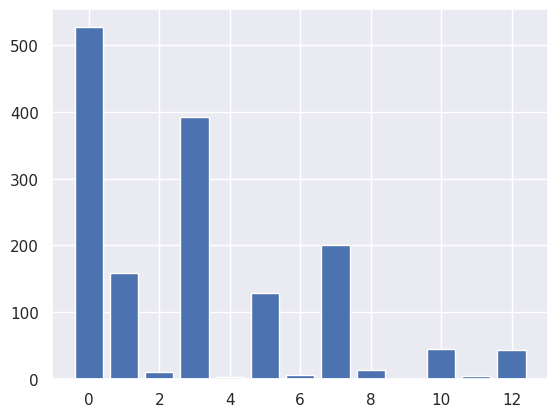

In [101]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

plt.bar(*np.unique(test_preds.values.argmax(axis=-1), return_counts=True))

## Submission

In [94]:
submission = pd.read_csv(f"{data_dir}/SampleSubmission.csv")
display(submission.head())

,Field ID,Wheat,Mustard,Lentil,No Crop,Green pea,Sugarcane,Garlic,Maize,Gram,Coriander,Potato,Bersem,Rice
0,11,0,0,0,0,0,0,0,0,0,0,0,0,0
1,13,0,0,0,0,0,0,0,0,0,0,0,0,0
2,19,0,0,0,0,0,0,0,0,0,0,0,0,0
3,21,0,0,0,0,0,0,0,0,0,0,0,0,0
4,25,0,0,0,0,0,0,0,0,0,0,0,0,0


In [95]:
submission["Wheat"] = test_preds[0].values
submission["Mustard"] = test_preds[1].values
submission["Lentil"] = test_preds[2].values
submission["No Crop"] = test_preds[3].values
submission["Green pea"] = test_preds[4].values
submission["Sugarcane"] = test_preds[5].values
submission["Garlic"] = test_preds[6].values
submission["Gram"] = test_preds[7].values
submission["Maize"] = test_preds[8].values
submission["Coriander"] = test_preds[9].values
submission["Potato"] = test_preds[10].values
submission["Bersem"] = test_preds[11].values
submission["Rice"] = test_preds[12].values

display(submission.head())

,Field ID,Wheat,Mustard,Lentil,No Crop,Green pea,Sugarcane,Garlic,Maize,Gram,Coriander,Potato,Bersem,Rice
0,11,0.198369,0.307153,0.021562,0.060585,0.001824,0.408436,0.000230,0.000128,0.000807,0.000031,0.000214,0.000032,0.000628
1,13,0.647160,0.141121,0.012155,0.183962,0.002682,0.008700,0.000838,0.000825,0.000022,0.000112,0.000299,0.001241,0.000884
2,19,0.410096,0.244448,0.037271,0.071812,0.001130,0.231556,0.001116,0.000400,0.000013,0.001831,0.000083,0.000226,0.000016
3,21,0.064258,0.221212,0.022651,0.546724,0.002912,0.129548,0.001611,0.000931,0.000283,0.000058,0.004604,0.004889,0.000319
4,25,0.226733,0.043620,0.179274,0.545272,0.000145,0.003960,0.000229,0.000545,0.000002,0.000047,0.000005,0.000156,0.000010


In [96]:
submission.to_csv(f"{data_dir}/submission.csv", index = False)